<a href="https://colab.research.google.com/github/ayasyrev/imagenette_experiments/blob/master/Twist_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twist experiments

> Experiments with Twist layer.

# setup and imports

In [ ]:
# pip install git+https://github.com/kornia/kornia

In [ ]:
# pip install git+https://github.com/ayasyrev/model_constructor

In [ ]:
# pip install git+https://github.com/ayasyrev/imagenette_experiments

In [ ]:
from imagenette_experiments.train_utils import *

In [ ]:
from fastai.basic_train import *
from fastai.vision import *
from model_constructor.net import Net, act_fn
from model_constructor.layers import SimpleSelfAttention, ConvLayer

# Twist

In [ ]:
from model_constructor.twist import *

Now we got Twist module, Twist layer and Twist Block.

In [ ]:
ConvTwist

model_constructor.twist.ConvTwist

In [ ]:
ConvLayerTwist

model_constructor.twist.ConvLayerTwist

ConvLayerTwist - same as base ConvLayer, bun Conv2D now Twist module.

In [ ]:
ConvLayerTwist.Conv2d

model_constructor.twist.ConvTwist

Now i use NewResBlockTwist, but later i'll uniform it - will be regular ResBlock with plugable Twist (or whatever).

In [ ]:
NewResBlockTwist

model_constructor.twist.NewResBlockTwist

# Model Constructor

In [ ]:
model = Net(c_out=10, layers=[3,4,6,3], expansion=4)

In [ ]:
model.block = NewResBlockTwist
model.stem_sizes = [3,32,64,64]
model.act_fn = Mish()
model.sa = True

## Model

Most interesting - body part.

In [ ]:
model.body.l_1.bl_0

NewResBlockTwist(
  (reduce): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (convs): Sequential(
    (conv_0): ConvLayer(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_1_twist): ConvLayerTwist(
      (conv): ConvTwist(
        twist: False, permute: True, same: True, groups: 16
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      )
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_2): ConvLayer(
      (conv): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (idconv): ConvLayer(
    (conv): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): Bat

## learner anf lr_find

In [ ]:
learn = get_learn(model=model, size=192, bs=32, mixup=0)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


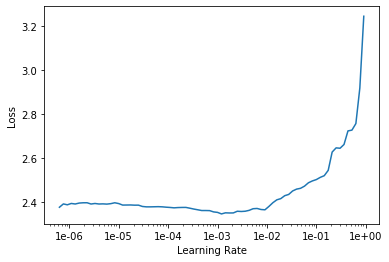

In [ ]:
learn.recorder.plot()

# Experiments

Now if we wont to experiment, we can just plug new version to model.

In [ ]:
class NewTwist(nn.Module):
    '''New twist, as example, self.twist is True...'''
    def __init__(self, ni, nf, 
                 ks=3, stride=1, padding=1, bias=False, 
                 groups=1, iters=1, init_max=0.7, twist = True, permute=True):
        super().__init__()
        self.twist = twist
        self.permute = permute
        self.same = ni==nf and stride==1
        if not (ni%groups==0 and nf%groups==0): groups = 1
        elif ni%64==0: groups = ni//8
        
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=stride, padding=1, bias=False, groups=groups)
        if self.twist:
            std = self.conv.weight.std().item()
            self.coeff_Ax = nn.Parameter(torch.empty((nf,ni//groups)).normal_(0, std), requires_grad=True)
            self.coeff_Ay = nn.Parameter(torch.empty((nf,ni//groups)).normal_(0, std), requires_grad=True)
        self.iters = iters
        self.stride = stride
        self.groups = groups
        self.DD = self.derivatives()

    def derivatives(self):
        I = torch.Tensor([[0,0,0],[0,1,0],[0,0,0]]).view(1,1,3,3)
        D_x = torch.Tensor([[-1,0,1],[-2,0,2],[-1,0,1]]).view(1,1,3,3) / 10
        D_y = torch.Tensor([[1,2,1],[0,0,0],[-1,-2,-1]]).view(1,1,3,3) / 10
        def convolution(K1, K2):
            return F.conv2d(K1, K2.flip(2).flip(3), padding=2)
        D_xx = convolution(I+D_x, I+D_x).view(5,5)
        D_yy = convolution(I+D_y, I+D_y).view(5,5)
        D_xy = convolution(I+D_x, I+D_y).view(5,5)
        return {'x': D_x, 'y': D_y, 'xx': D_xx, 'yy': D_yy, 'xy': D_xy}

    def kernel(self, coeff_x, coeff_y):
        D_x = torch.Tensor([[-1,0,1],[-2,0,2],[-1,0,1]]).to(coeff_x.device)
        D_y = torch.Tensor([[1,2,1],[0,0,0],[-1,-2,-1]]).to(coeff_x.device)
        return coeff_x[:,:,None,None] * D_x + coeff_y[:,:,None,None] * D_y

    def full_kernel(self, kernel): # permuting the groups
        if self.groups==1: return kernel
        n = self.groups
        a,b,_,_ = kernel.size()
        a = a//n
        KK = torch.zeros((a*n,b*n,3,3)).to(kernel.device)
        # KK[:a,-b:] = kernel[:a]
        for i in range(n):
            if i%4==0:
                KK[a*i:a*(i+1),b*(i+3):b*(i+4)] = kernel[a*i:a*(i+1)]
            else:
                KK[a*i:a*(i+1),b*(i-1):b*i] = kernel[a*i:a*(i+1)]
        return KK

    def _conv(self, inpt, kernel=None):
        permute = True
        if kernel is None:
            kernel = self.conv.weight
        if permute is False:
            return F.conv2d(inpt, kernel, padding=1, stride=self.stride, groups=self.groups)
        else:
            return F.conv2d(inpt, self.full_kernel(kernel), padding=1, stride=self.stride, groups=1)

    def symmetrize(self, conv_wt):
        # conv_wt.data = (conv_wt - conv_wt.flip(2).flip(3)) / 2
        if self.same:
            n = conv_wt.size()[1]
            for i in range(self.groups):
                conv_wt.data[n*i:n*(i+1)] = (conv_wt[n*i:n*(i+1)] + torch.transpose(conv_wt[n*i:n*(i+1)],0,1)) / 2

    def forward(self, inpt):
        out = self._conv(inpt)
        if self.twist is False:
            return out
        _,_,h,w = out.size()
        XX = torch.from_numpy(np.indices((1,1,h,w))[3]*2/w-1).type(out.dtype).to(out.device) 
        YY = torch.from_numpy(np.indices((1,1,h,w))[2]*2/h-1).type(out.dtype).to(out.device)
        
        kernel_x = self.kernel(self.coeff_Ax, self.coeff_Ay)
        self.symmetrize(kernel_x)
        kernel_y = kernel_x.transpose(2,3).flip(3)  # make conv_y a 90 degree rotation of conv_x
        out = out + XX * self._conv(inpt, kernel_x) + YY * self._conv(inpt, kernel_y)
        if self.same and self.iters>1:
            out = inpt + out / self.iters
            for _ in range(self.iters-1):
                out = out + (self._conv(out) + XX * self._conv(out, kernel_x) + YY * self._conv(out, kernel_y)) / self.iters
            out = out - inpt
        return out
      
    def extra_repr(self):
        return f"twist: {self.twist}, permute: {self.permute}, same: {self.same}, groups: {self.groups}"

In [ ]:
ConvLayerTwist.Conv2d

model_constructor.twist.ConvTwist

In [ ]:
ConvLayerTwist.Conv2d = NewTwist

In [ ]:
ConvLayerTwist.Conv2d

__main__.NewTwist

Lets check!  

In [ ]:
model.body.l_1.bl_0

NewResBlockTwist(
  (reduce): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (convs): Sequential(
    (conv_0): ConvLayer(
      (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_1_twist): ConvLayerTwist(
      (conv): NewTwist(
        twist: True, permute: True, same: True, groups: 16
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
      )
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_2): ConvLayer(
      (conv): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (idconv): ConvLayer(
    (conv): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): Batch

# end